## Super Res GANs

In [1]:
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [7]:
il = ImageList.from_folder(path_hr)

In [8]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [9]:
il

ImageList (7390 items)
Image (3, 333, 500),Image (3, 325, 500),Image (3, 333, 500),Image (3, 377, 500),Image (3, 500, 428)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images

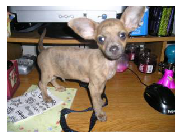

In [11]:
il[50].show()

In [12]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /home/jupyter/.fastai/data/oxford-iiit-pet/small-96
resizing to 256 into /home/jupyter/.fastai/data/oxford-iiit-pet/small-256


In [21]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [22]:
def return_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [23]:
data = return_data(bs, size)

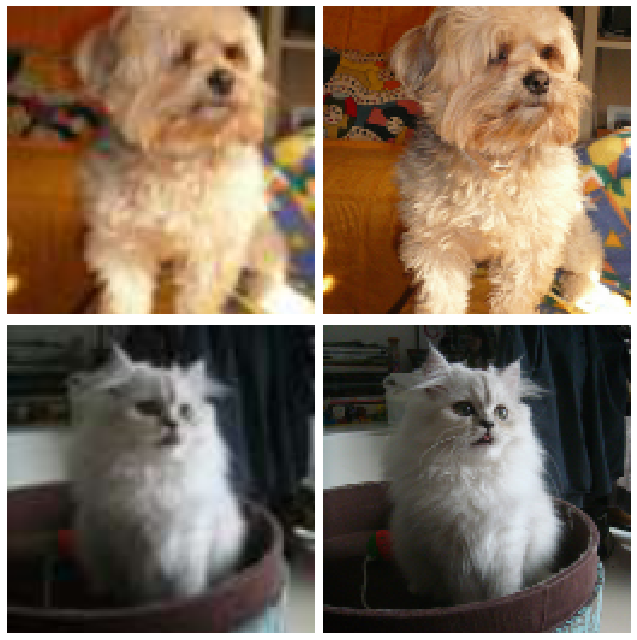

In [28]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))